In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
tqdm.pandas()

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/est-
[nltk_data]     lul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/est-lul/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_parquet('../data/complaints.parquet')

In [3]:
df.shape

(9609797, 18)

In [4]:
print(df.isna().sum())

Date received                         0
Product                               0
Sub-product                      235295
Issue                                 6
Sub-issue                        839522
Consumer complaint narrative    6629041
Company public response         4770207
Company                               0
State                             54516
ZIP code                          30228
Tags                            8981029
Consumer consent provided?      1649561
Submitted via                         0
Date sent to company                  0
Company response to consumer         20
Timely response?                      0
Consumer disputed?              8841498
Complaint ID                          0
dtype: int64


In [5]:
df.sample(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
7535345,2023-11-20,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account status incorrect,I kindly implore you to immediately correct th...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IL,601XX,None,Consent provided,Web,2023-11-20,Closed with explanation,Yes,None,7880604
9310350,2024-03-19,Debt or credit management,Debt settlement,Charged upfront or unexpected fees,None,None,None,Northstar Legal Group LLC,MN,56226,Older American,None,Phone,2024-03-19,Untimely response,No,None,8584207
6727158,2014-08-28,Consumer Loan,Vehicle loan,Managing the loan or lease,None,None,None,Santander Consumer USA Holdings Inc.,IL,60173,None,None,Web,2014-09-03,Closed with explanation,Yes,No,1005179
4844068,2025-05-06,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,None,None,Experian Information Solutions Inc.,MD,20785,None,None,Web,2025-05-06,In progress,Yes,None,13368827
6436929,2014-12-21,Credit reporting,None,Credit reporting company's investigation,Investigation took too long,None,None,"EQUIFAX, INC.",AL,35040,None,None,Web,2014-12-24,Closed with explanation,Yes,No,1165609


In [6]:
target_products = [
    'Credit card', 'Credit card or prepaid card', 
    'Payday loan, title loan, or personal loan', 'Payday loan, title loan, personal loan, or advance loan',
    'Bank account or service',
    'Money transfers'
]

In [7]:
df['Product'].value_counts()

Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
Vehicle loan or lease   

In [8]:
df = df[df['Product'].isin(target_products)]
df.shape

(571769, 18)

In [19]:
# Number of complaints with narratives (non-empty)
with_narrative = df['Consumer complaint narrative'].notna() & (df['Consumer complaint narrative'].str.strip() != '')
print("Complaints with narratives:", with_narrative.sum())

# Number of complaints without narratives (empty or NaN)
without_narrative = ~with_narrative
print("Complaints without narratives:", without_narrative.sum())

Complaints with narratives: 231850
Complaints without narratives: 0


In [9]:
#Drop rows with missing or empty narratives
df = df.dropna(subset=['Consumer complaint narrative'])
df = df[df['Consumer complaint narrative'].str.strip() != '']

In [10]:
df.shape

(231850, 18)

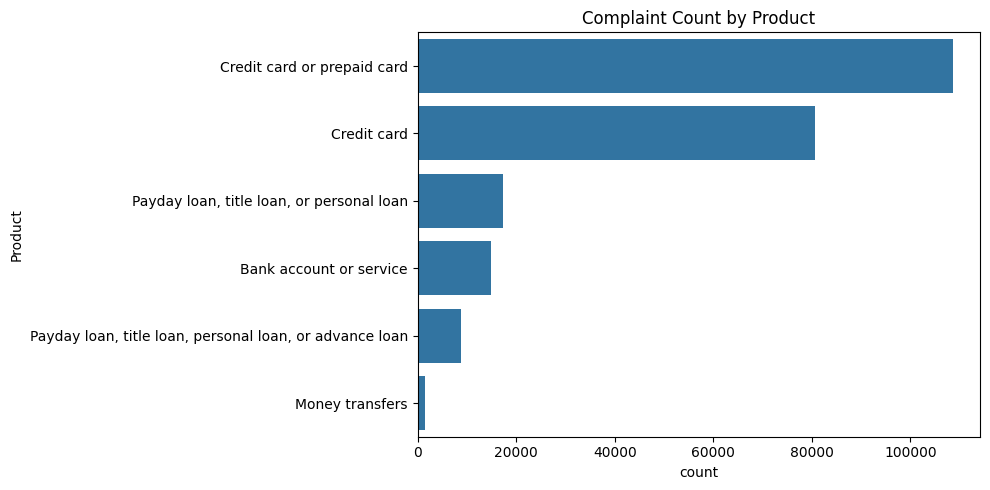

In [11]:
# Visualize product distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='Product', order=df['Product'].value_counts().index)
plt.title("Complaint Count by Product")
plt.tight_layout()

In [12]:
# Add narrative length column
df['narrative_length'] = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))

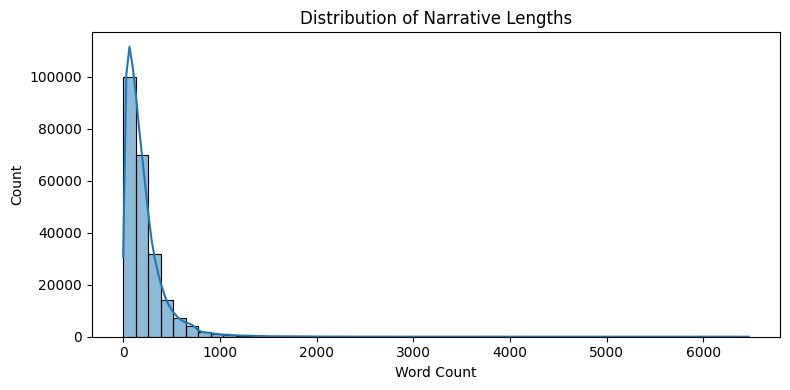

In [13]:
# Visualize narrative length
plt.figure(figsize=(8, 4))
sns.histplot(df['narrative_length'], bins=50, kde=True)
plt.title("Distribution of Narrative Lengths")
plt.xlabel("Word Count")
plt.tight_layout()
plt.show()

## Clean Text

The clean_text function takes a string and performs basic text cleaning:

- Converts all characters to lowercase.
- Removes any character that is not a lowercase letter, digit, or whitespace.
- Replaces multiple spaces with a single space and trims leading/trailing spaces.

This prepares text for further analysis or modeling by standardizing and simplifying it.

In [23]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

In [24]:
df['cleaned_narrative'] = df['Consumer complaint narrative'].progress_apply(clean_text)

Exception ignored in: <function tqdm.__del__ at 0x7f6860ae9750>
Traceback (most recent call last):
  File "/home/est-lul/Documents/Projects/intelligent_complaint_analysis/.venv/lib64/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/est-lul/Documents/Projects/intelligent_complaint_analysis/.venv/lib64/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
100%|██████████| 231850/231850 [02:07<00:00, 1820.27it/s]


In [25]:
df.to_parquet('../data/processed/filtered_complaints.parquet', index=False)